# **LSTM, CNN, and Electrocardiogram**


We work on preprocessing electrocardiogram (EKG) data and building networks to classify different types of EKG.

The dataset we will use is from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/shayanfazeli/heartbeat). It contains more than 100,000 samples and five classes (0=N, 1=S, 2=V, 3=F, 4=Q). Both the training and the testing datasets are matrices. Each row of each matrix represents an example signal for a given class. The final element of each row is the class to which that example belongs.

In [2]:
# import

import sys
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [5]:
training_data = pd.read_csv('mitbih_train.csv', header=None)
test_data = pd.read_csv('mitbih_test.csv', header=None)

In [6]:
training_data[187]=training_data[187].astype(int)
df_1=training_data[training_data[187]==0]
df_2=training_data[training_data[187]==1]
df_3=training_data[training_data[187]==2]
print(df_1.shape, df_2.shape, df_3.shape)
training_data=pd.concat([df_1,df_2, df_3])

test_data[187]=test_data[187].astype(int)
df_1=test_data[test_data[187]==0]
df_2=test_data[test_data[187]==1]
df_3=test_data[test_data[187]==2]
print(df_1.shape, df_2.shape, df_3.shape)
test_data=pd.concat([df_1,df_2, df_3])

(72471, 188) (2223, 188) (5788, 188)
(18118, 188) (556, 188) (1448, 188)


In [7]:
# convert to numpy array
training_data = training_data.to_numpy()
test_data = test_data.to_numpy()

In [8]:
label_train = training_data[:,-1]
data_train = np.expand_dims(training_data[:,:-1], axis = 2)

number_of_rows = label_train.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows/10), replace=False)

data_val = data_train[random_indices, :, :]
label_val = label_train[random_indices]

label_train = np.delete(label_train, random_indices)
data_train = np.delete(data_train, random_indices, 0)


label_test = test_data[:,-1]
data_test = np.expand_dims(test_data[:,:-1], axis = 2)

In [9]:
print(data_train.shape, data_val.shape, data_test.shape)

(72434, 187, 1) (8048, 187, 1) (20122, 187, 1)


In [6]:
# Evaluation function
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)


**CNN**


In [44]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LSTM

def network(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    

    conv1d_1 = Conv1D(64, 6, use_bias=True)(inputs_cnn) # From the formula above, K = -(182-1) + 187 = 6
    batch_normalization = BatchNormalization(synchronized=True)(conv1d_1)
    max_pooling1d = MaxPooling1D(pool_size=2, strides=None, padding="same")(batch_normalization) # Pool size 2 = 182/91
    conv1d_2 = Conv1D(128, 3, use_bias=True)(max_pooling1d) # From the formula above, K = -(89-1) + 91 = 3
    batch_normalization_1 = BatchNormalization(synchronized=True)(conv1d_2)
    max_pooling1d_1 = MaxPooling1D(pool_size=2, strides=None, padding="same")(batch_normalization_1)
    flat = Flatten()(max_pooling1d_1)
    dense = Dense(64, activation='relu')(flat)
    dense_1 = Dense(32, activation='relu')(dense)
    main_output = Dense(3, activation='softmax')(dense_1)


    model_cnn = Model(inputs= inputs_cnn, outputs=main_output)
    model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model_cnn)

In [45]:
model_cnn = network(data_train,label_train)
print(model_cnn.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 187, 1)]          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 182, 64)           448       
                                                                 
 batch_normalization_20 (Ba  (None, 182, 64)           256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 91, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_18 (Conv1D)          (None, 89, 128)           24704     
                                                                 
 batch_normalization_21 (Ba  (None, 89, 128)           512

In [46]:
history_cnn = model_cnn.fit(data_train, label_train,epochs=10, batch_size=64,validation_data=(data_val,label_val))

Epoch 1/10
1132/1132 [==============================] - 17s 12ms/step - loss: 0.1244 - accuracy: 0.9661 - val_loss: 0.0941 - val_accuracy: 0.9763
Epoch 2/10
1132/1132 [==============================] - 8s 7ms/step - loss: 0.0801 - accuracy: 0.9783 - val_loss: 0.0804 - val_accuracy: 0.9791
Epoch 3/10
1132/1132 [==============================] - 7s 6ms/step - loss: 0.0671 - accuracy: 0.9809 - val_loss: 0.0793 - val_accuracy: 0.9783
Epoch 4/10
1132/1132 [==============================] - 6s 5ms/step - loss: 0.0601 - accuracy: 0.9834 - val_loss: 0.0781 - val_accuracy: 0.9800
Epoch 5/10
1132/1132 [==============================] - 7s 6ms/step - loss: 0.0543 - accuracy: 0.9838 - val_loss: 0.0776 - val_accuracy: 0.9779
Epoch 6/10
1132/1132 [==============================] - 6s 5ms/step - loss: 0.0489 - accuracy: 0.9855 - val_loss: 0.0964 - val_accuracy: 0.9740
Epoch 7/10
1132/1132 [==============================] - 7s 7ms/step - loss: 0.0432 - accuracy: 0.9865 - val_loss: 0.0795 - val_accurac

Accuracy: 98.20%


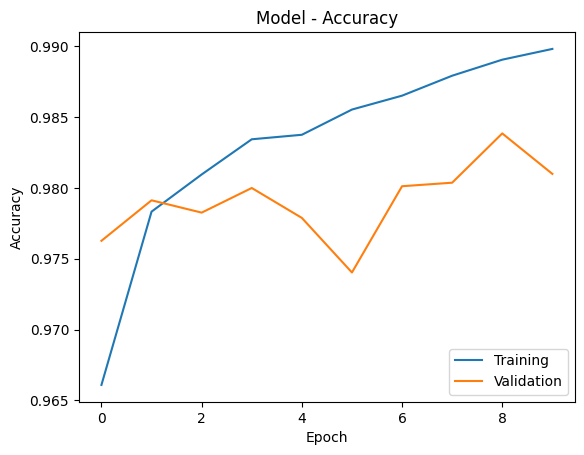

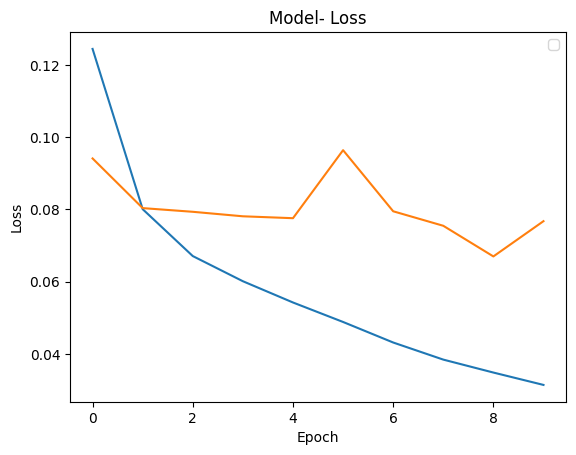

629/629 [==============================] - 1s 2ms/step


In [48]:
evaluate_model(history_cnn,data_test,label_test,model_cnn)
y_pred_cnn=model_cnn.predict(data_test)

**LSTM**

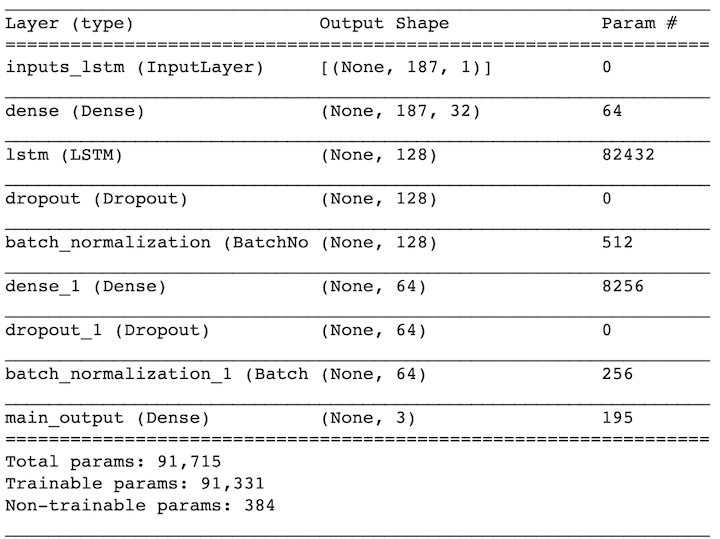

In [49]:
def network_LSTM(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')

    dense = Dense(32, activation='relu')(inputs_lstm)
    lstm = LSTM(128)(dense)
    dropout = Dropout(0.2)(lstm)
    batch_normalization = BatchNormalization(synchronized=True)(dropout)
    dense_1 = Dense(64, activation='relu')(batch_normalization)
    dropout_1 = Dropout(0.2)(dense_1)
    batch_normalization_1 = BatchNormalization(synchronized=True)(dropout_1)
    main_output = Dense(3, activation='softmax')(batch_normalization_1)

    model_lstm = Model(inputs= inputs_lstm, outputs=main_output)
    model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model_lstm)

In [50]:
model_lstm = network_LSTM(data_train,label_train)
print(model_lstm.summary())

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 187, 1)]          0         
                                                                 
 dense_33 (Dense)            (None, 187, 32)           64        
                                                                 
 lstm_3 (LSTM)               (None, 128)               82432     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_22 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                          

In [51]:
history_lstm = model_lstm.fit(data_train,label_train,epochs=10, batch_size=64,validation_data=(data_val,label_val))

Epoch 1/10
1132/1132 [==============================] - 23s 18ms/step - loss: 0.4457 - accuracy: 0.8824 - val_loss: 0.3873 - val_accuracy: 0.9022
Epoch 2/10
1132/1132 [==============================] - 21s 19ms/step - loss: 0.3759 - accuracy: 0.9000 - val_loss: 0.3642 - val_accuracy: 0.9062
Epoch 3/10
1132/1132 [==============================] - 19s 16ms/step - loss: 0.3734 - accuracy: 0.9000 - val_loss: 0.3610 - val_accuracy: 0.9067
Epoch 4/10
1132/1132 [==============================] - 14s 12ms/step - loss: 0.3747 - accuracy: 0.9001 - val_loss: 0.3635 - val_accuracy: 0.9048
Epoch 5/10
1132/1132 [==============================] - 14s 12ms/step - loss: 0.3727 - accuracy: 0.9004 - val_loss: 0.3670 - val_accuracy: 0.9058
Epoch 6/10
1132/1132 [==============================] - 14s 12ms/step - loss: 0.3740 - accuracy: 0.9002 - val_loss: 0.3641 - val_accuracy: 0.9044
Epoch 7/10
1132/1132 [==============================] - 14s 12ms/step - loss: 0.3729 - accuracy: 0.8997 - val_loss: 0.3625 -

Accuracy: 91.74%


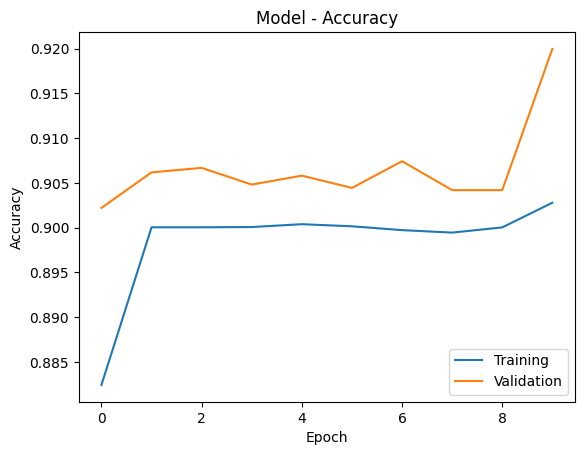

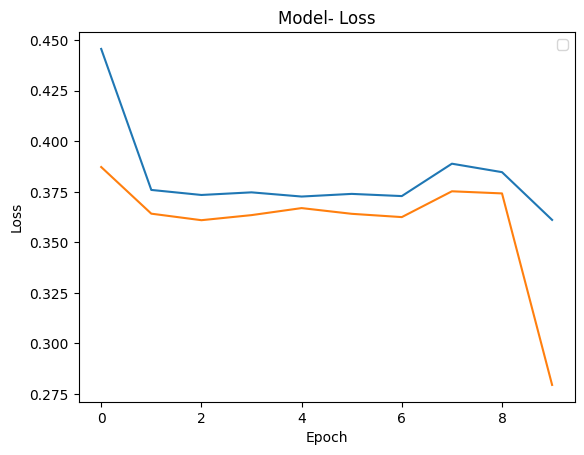

629/629 [==============================] - 3s 4ms/step


In [52]:
evaluate_model(history_lstm,data_test,label_test,model_lstm)
y_pred_lstm = model_lstm.predict(data_test)

**CNN & LSTM**


In [37]:
def network_CNN_LSTM(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn_lstm=Input(shape=(im_shape), name='inputs_cnn_lstm')

    conv1d_1 = Conv1D(64, 6, use_bias=True)(inputs_cnn_lstm) # From the formula above, K = -(182-1) + 187 = 6
    batch_normalization = BatchNormalization(synchronized=True)(conv1d_1)
    max_pooling1d = MaxPooling1D(pool_size=2, strides=None, padding="same")(batch_normalization) # Pool size 2 = 182/91
    conv1d_2 = Conv1D(128, 3, use_bias=True)(max_pooling1d) # From the formula above, K = -(89-1) + 91 = 3
    batch_normalization_1 = BatchNormalization(synchronized=True)(conv1d_2)
    max_pooling1d_1 = MaxPooling1D(pool_size=2, strides=None, padding="same")(batch_normalization_1)
    lstm = LSTM(128)(max_pooling1d_1)
    flat = Flatten()(lstm)
    dense = Dense(64, activation='relu')(flat)
    dense_1 = Dense(32, activation='relu')(dense)
    main_output = Dense(3, activation='softmax')(dense_1)


    model = Model(inputs=inputs_cnn_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [53]:
model_mix =network_CNN_LSTM(data_train,label_train)
print(model_mix.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn_lstm (InputLaye  [(None, 187, 1)]          0         
 r)                                                              
                                                                 
 conv1d_19 (Conv1D)          (None, 182, 64)           448       
                                                                 
 batch_normalization_24 (Ba  (None, 182, 64)           256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 91, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_20 (Conv1D)          (None, 89, 128)           24704     
                                                          

In [54]:
history_mix = model_mix.fit(data_train,label_train,epochs=10, batch_size=64,validation_data=(data_val,label_val))

Epoch 1/10
1132/1132 [==============================] - 26s 15ms/step - loss: 0.1984 - accuracy: 0.9464 - val_loss: 0.1383 - val_accuracy: 0.9643
Epoch 2/10
1132/1132 [==============================] - 10s 9ms/step - loss: 0.1046 - accuracy: 0.9728 - val_loss: 0.0996 - val_accuracy: 0.9722
Epoch 3/10
1132/1132 [==============================] - 9s 8ms/step - loss: 0.0875 - accuracy: 0.9767 - val_loss: 0.0864 - val_accuracy: 0.9784
Epoch 4/10
1132/1132 [==============================] - 10s 9ms/step - loss: 0.0737 - accuracy: 0.9806 - val_loss: 0.0718 - val_accuracy: 0.9817
Epoch 5/10
1132/1132 [==============================] - 10s 9ms/step - loss: 0.0707 - accuracy: 0.9808 - val_loss: 0.0703 - val_accuracy: 0.9816
Epoch 6/10
1132/1132 [==============================] - 10s 9ms/step - loss: 0.0625 - accuracy: 0.9834 - val_loss: 0.0686 - val_accuracy: 0.9821
Epoch 7/10
1132/1132 [==============================] - 10s 9ms/step - loss: 0.0557 - accuracy: 0.9850 - val_loss: 0.0656 - val_ac

Accuracy: 98.29%


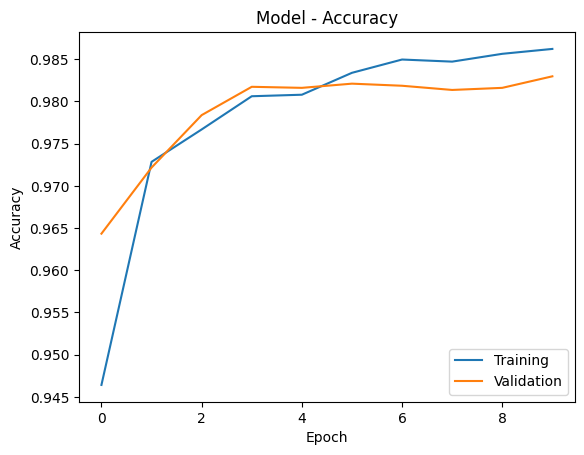

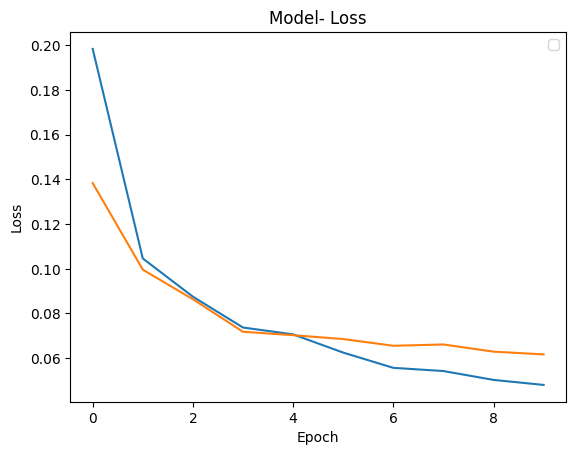

629/629 [==============================] - 2s 3ms/step


In [55]:
evaluate_model(history_mix,data_test,label_test,model_mix)
y_pred_mix = model_mix.predict(data_test)


In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

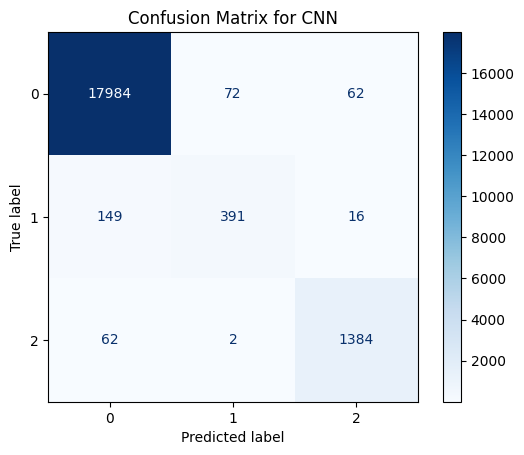

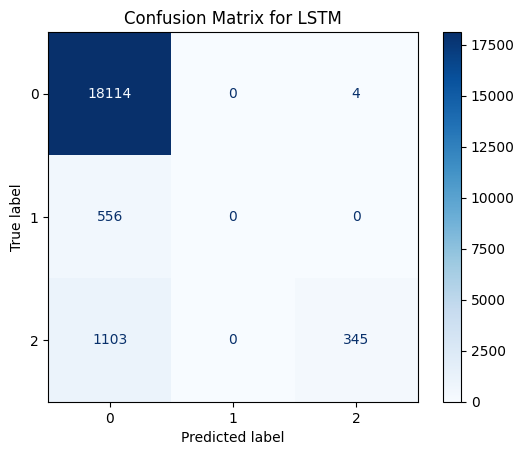

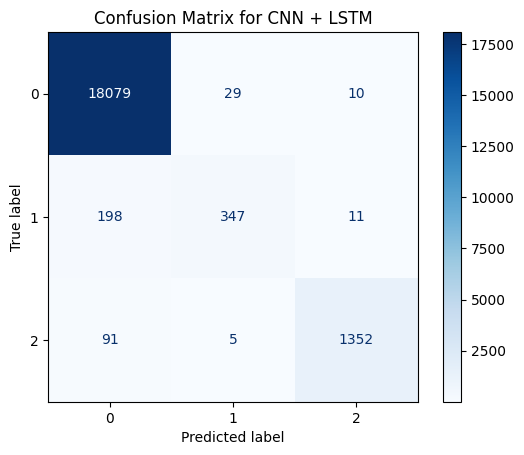

In [104]:
from matplotlib.pyplot import subplot
from matplotlib.pyplot import figure

y_prediction_cnn = np.argmax (y_pred_cnn, axis = 1)
cm = confusion_matrix(label_test, y_prediction_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN')

y_prediction_lstm = np.argmax (y_pred_lstm, axis = 1)
cm = confusion_matrix(label_test, y_prediction_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LSTM')

y_prediction_mix = np.argmax (y_pred_mix, axis = 1)
cm = confusion_matrix(label_test, y_prediction_mix)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN + LSTM')
plt.show()

We can also look at the prediction accuracy for each model.

Classification report for CNN
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.84      0.70      0.77       556
         2.0       0.95      0.96      0.95      1448

    accuracy                           0.98     20122
   macro avg       0.93      0.88      0.90     20122
weighted avg       0.98      0.98      0.98     20122

Classification report for LSTM
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     18118
         1.0       0.00      0.00      0.00       556
         2.0       0.99      0.24      0.38      1448

    accuracy                           0.92     20122
   macro avg       0.63      0.41      0.45     20122
weighted avg       0.90      0.92      0.89     20122

Classification report for CNN + LSTM
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18118
         1.0       0.91      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


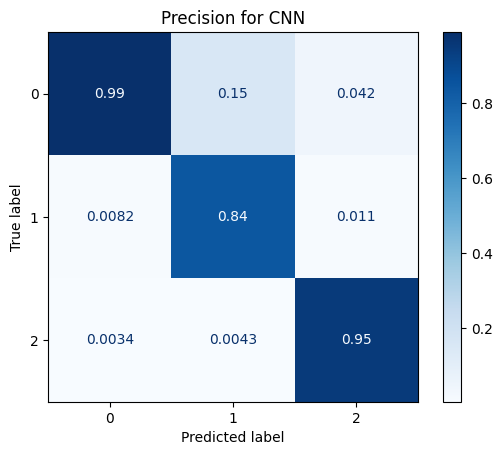

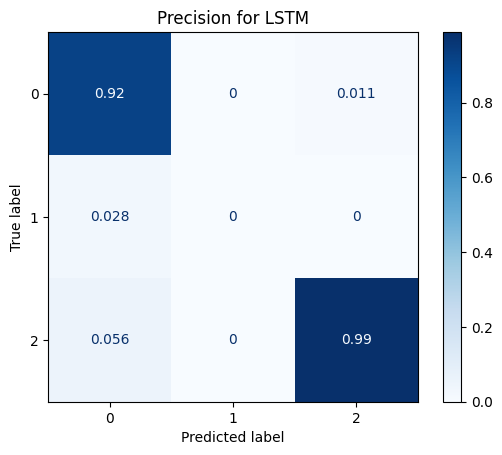

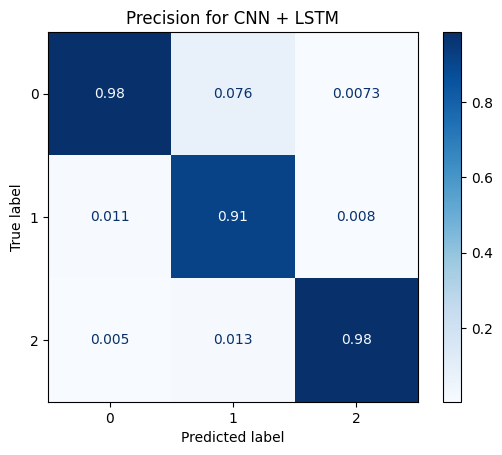

In [111]:
from sklearn.metrics import classification_report

print('Classification report for CNN')
print(classification_report(label_test, y_prediction_cnn))

print('Classification report for LSTM')
print(classification_report(label_test, y_prediction_lstm))

print('Classification report for CNN + LSTM')
print(classification_report(label_test, y_prediction_mix))

y_prediction_cnn = np.argmax (y_pred_cnn, axis = 1)
cm = confusion_matrix(label_test, y_prediction_cnn, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Precision for CNN')

y_prediction_lstm = np.argmax (y_pred_lstm, axis = 1)
cm = confusion_matrix(label_test, y_prediction_lstm, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Precision for LSTM')

y_prediction_mix = np.argmax (y_pred_mix, axis = 1)
cm = confusion_matrix(label_test, y_prediction_mix, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Precision for CNN + LSTM')
plt.show()

The accuracies for each model were:


> 98.20% for CNN
<br>
> 91.74% for LSTM
<br>
> 98.29% CNN + LSTM

The best model is therefore the CNN + LSTM, as it had the highest accuracy score, and also the smoother curves for accuracy and loss after 10 epochs compared to just CNN. The LSTM model is performing poorly. The CNN + LSTM model outperforms the others because the data is 2D + time, and it supports both the spatial components and the time components.


In [9]:
training_data = pd.read_csv('mitbih_train.csv', header=None)
test_data = pd.read_csv('mitbih_test.csv', header=None)
training_data[187]=training_data[187].astype(int)
test_data[187]=test_data[187].astype(int)

df_3=training_data[training_data[187]==2]
df_4=training_data[training_data[187]==3]
df_5=training_data[training_data[187]==4]

print(df_3.shape, df_4.shape, df_5.shape)
print(len(training_data))


# Your code

df_3=test_data[test_data[187]==2]
df_4=test_data[test_data[187]==3]
df_5=test_data[test_data[187]==4]

print(df_3.shape, df_4.shape, df_5.shape)
test_data=pd.concat([df_3,df_4, df_5])

training_data = training_data.to_numpy()
test_data = test_data.to_numpy()

label_train = training_data[:,-1]
data_train = np.expand_dims(training_data[:,:-1], axis = 2)

number_of_rows = label_train.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows/10), replace=False)

data_val = data_train[random_indices, :, :]
label_val = label_train[random_indices]

label_train = np.delete(label_train, random_indices)
data_train = np.delete(data_train, random_indices, 0)


label_test = test_data[:,-1]
data_test = np.expand_dims(test_data[:,:-1], axis = 2)


(5788, 188) (641, 188) (6431, 188)
87554
(1448, 188) (162, 188) (1608, 188)


In [134]:
# We need to shift the labels

for i in range(3,6):
  label_train[label_train==i] = i-3
  label_val[label_val==i] = i-3
  label_test[label_test==i] = i-3

In [135]:
model_new = network_CNN_LSTM(data_train,label_train)


Epoch 1/10
181/181 [==============================] - 6s 12ms/step - loss: 0.4906 - accuracy: 0.7803 - val_loss: 2.3308 - val_accuracy: 0.4401
Epoch 2/10
181/181 [==============================] - 2s 8ms/step - loss: 0.2526 - accuracy: 0.9039 - val_loss: 1.4820 - val_accuracy: 0.5568
Epoch 3/10
181/181 [==============================] - 2s 8ms/step - loss: 0.1635 - accuracy: 0.9436 - val_loss: 0.3217 - val_accuracy: 0.8779
Epoch 4/10
181/181 [==============================] - 1s 8ms/step - loss: 0.1233 - accuracy: 0.9600 - val_loss: 0.1221 - val_accuracy: 0.9596
Epoch 5/10
181/181 [==============================] - 2s 8ms/step - loss: 0.0963 - accuracy: 0.9701 - val_loss: 0.1199 - val_accuracy: 0.9541
Epoch 6/10
181/181 [==============================] - 2s 11ms/step - loss: 0.0901 - accuracy: 0.9719 - val_loss: 0.1857 - val_accuracy: 0.9339
Epoch 7/10
181/181 [==============================] - 2s 11ms/step - loss: 0.0762 - accuracy: 0.9774 - val_loss: 0.1723 - val_accuracy: 0.9432
Epo

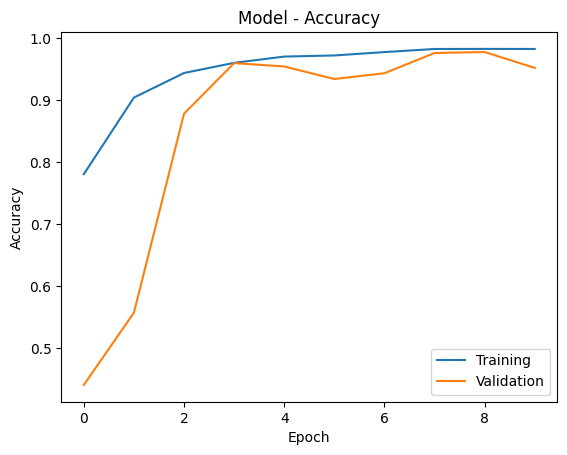

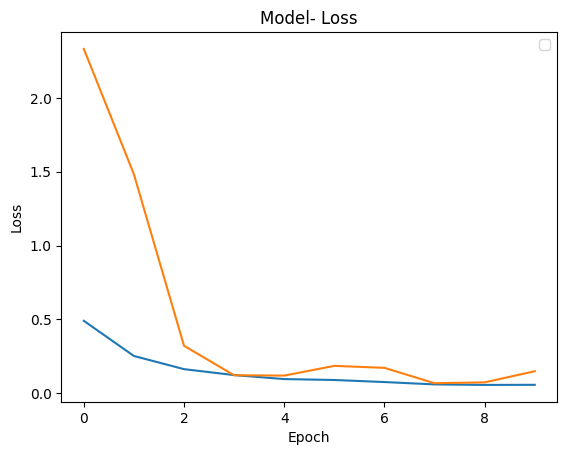

101/101 [==============================] - 0s 3ms/step


In [136]:
history_new =model_new.fit(data_train,label_train,epochs=10, batch_size=64,validation_data=(data_val,label_val))
evaluate_model(history_new,data_test,label_test,model_new)
y_pred=model_new.predict(data_test)

The new acuracy is 93.8%, which is smaller than for the previous dataset with 98.29%. This might be due to the difference in dataset size: for the first datset, the training set had a total number of 80 482 samples, compared to only 12 860 for the second dataset.